| Universidad de los Andes<br>Departamento de Ingeniería Eléctrica y Electrónica<br>Curso de Educación Contínua<br><br><p style="font-size:60px">Reinforcement Learning</p> 	|<figure><img src='https://drive.google.com/uc?export=view&id=1F8nsfZCkL_qkQWzY9C80MQ_GyvPvPpqW' width=250/></figure>	|
|-----------------------------------------------------------------------------------	|---	|


Bienvenido al módulo 3 del curso sobre aprendizaje por refuerzo. En este ejercicio exploraremos la utilidad y funcionamiento de las redes convolucionales. Luego, utilizaremos una red neuronal convolucional para clasificar dos niveles del juego de atari Super Mario bros a partir de imágenes del mismo.<br>

**En esta actividad reforzarás los siguientes métodos:** aplicación de redes neuronales convolucionales, entornos gym de OpenAI

En principio es importar ejecutar las siguientes lineas para instalar los paquetes adicionales con los que Google Colab no cuenta y que necesitaremos a lo largo de este ejercicio

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym-super-mario-bros > /dev/null 2>&1

# Introducción a redes convolucionales

## Clasificación de niveles Super Mario Bros (Data set)


Uno de los ambientes más utilizados en el área de aprendizaje por refuerzo son los relacionados con los juegos de video. Entre ellos se encuentran los juegos de vídeo antiguos y sencillos como lo eran lo del *Nintendo Entrenimient System (NES)* y sus íconos más representativos a lo largo de la historia como lo fue Super Mario Bros. 

Es por esto que dentro del entorno de trabajo de *Open AI Gym* se ha seleccionado dicho entorno para introducir el concepto de redes convolucionales. Con esto en mente, el objetivo de este ejercicio es clasificar que imágenes corresponden al **Nivel 1** del juego de Super Mario Bros 1 y que imágenes corresponden al **Nivel 8** del mismo juego. 

El dataset disponible contiene imágenes de los dos niveles de Super Mario bros a clasificar y se encuentra adjunta en una carpeta a este Notebook. Cada dato contiene una imagen estática de alguna parte de cualquiera de las etapas del nivel o clase en cuestión. Vale la pena aclarar que cada uno de los niveles contiene cuatro etapas diferentes en donde varía el entorno, los obstaculos y los enemigos a los cuales se debe enfrentar Mario. 

El objetivo será entonces diseñar y entrenar una red convolucional sencilla y pequeña de forma que su entrenamiento no requiera mayor costo computacional.

A continuación se muestra un ejemplo de las imágenes de la etepa 1 de ambas clases a clasificar:

**Nota:** Solo deben editar aquellas celdas con el etiqueta #EDITABLE

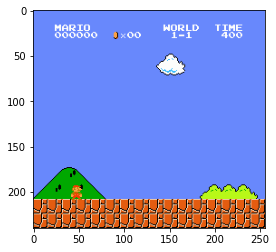

In [ ]:
# Importación de paquetes necesarios para mostrar imágenes
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from IPython.display import clear_output
import time
# Imagen del nivel 1 - Etapa 1
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())
screen = env.render(mode='rgb_array')
plt.imshow(screen)
env.close()

Ahora bien para visualizar alguna de las imágenes de la segunda clase (Nivel 8) completa la siguiente celda:

_A tener en cuenta:_ La sintaxis del ambiente de Mario Bros es:

'SuperMarioBros-Nivel-Etapa-v0'

En donde cada nivel cuenta con 4 etapas por separado y el ambiente un total de 8 niveles. Para este problema en especifico, solo manejaremos los niveles 1 y 8. 

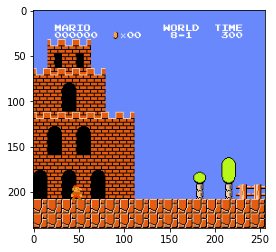

In [ ]:
# Imagen del nivel 8 - Etapa 1
# EDITABLE
env = gym_super_mario_bros.make('SuperMarioBros-8-1-v0') # borrar
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())
screen = env.render(mode='rgb_array') # borrar
plt.imshow(screen) # borrar
env.close()

In [ ]:
# Activar el acceso a Google Drive para acceder a la base de datos dada
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Con el fin de importar el dataset para poder entrenar nuestra primera red convolucional clonamos un repositorio de GitHub de la siguiente manera:

In [ ]:
# clonamos los archivos auxiliares para este notebook
! git clone https://github.com/jgarcia10/cursoRL-modulo5.git

Cloning into 'cursoRL-modulo5'...
remote: Enumerating objects: 9749, done.
remote: Total 9749 (delta 0), reused 0 (delta 0), pack-reused 9749
Receiving objects: 100% (9749/9749), 128.28 MiB | 30.11 MiB/s, done.
Resolving deltas: 100% (288/288), done.
Checking out files: 100% (10001/10001), done.


In [ ]:
cd 'cursoRL-modulo5'

/content/cursoRL-modulo5


## Importar y división del dataset 

En primer lugar es importante importar la base de datos adjunta al notebook presente para poder resolver el problema de clasificación.  De forma adicional y paralelamente se creará un vector de etiquetas (**_Y_**) que contenga la clase a la que pertenece cada imagen (Clase 0 si la imagen pertenece al nivel 1 o Clase 1 si la imagen pertenece al nivel 8)




In [ ]:
# Importación de los paquetes necesario para: Import Dataset
import cv2
import random
import os
import numpy as np


Vale la pena aclarar que originalmente los datos ya se encuentran divididos en: **Entrenamiento, Validación y Test** teniendo la siguiente distribución: 

* Entrenamiento: 3500 imágenes (70%)
*  Validación: 750 imágenes (15%)
*  Test: 750 imágenes (15%)

Esto con el objetivo de poder entrenar diferentes modelos con los mismos datos pero validando sus parámetros con datos diferentes para así comprobar su precisión de clasificación. Finalmente los datos de _Test_ restantes son para concluir cuál es el desempeño final del clasificador. Con esto en mente es necesario creer no solamente un vector de **X** y **Y** donde se apile toda la información, sino se debe crear diferentes vectores de entrenamiento, validación y test según corresponda el caso. 

**Vale la pena aclarar que dado el volumen de datos su importación tarda unos minutos**

In [ ]:
# Creacion de los vectores vacíos para almacenar los datos
X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = [] 
# Creación de variables para la importación de las imágenes
CATEGORIES = ['Nivel 1', 'Nivel 8']
FOLDERS = ['Train','Test','Validation']
# Importación de los datos
for folder in FOLDERS:
  data = [] # Variable temporal
  for category in CATEGORIES:
        path = os.path.join(category, folder)
        class_num_0 = CATEGORIES.index(category)
        for img in os.listdir(path):
          try:
            img_array = cv2.imread(os.path.join(path,img))
            data.append([img_array,class_num_0])
          except Exception as e:
            print("Not working")
            pass
        print(category+' of '+folder+' imported data done')
  random.shuffle(data)
  # Asignación de los datos de entrenamiento, validación o test:
  for features, label in data:
    if folder == 'Train':
      X_train.append(features)
      Y_train.append(label)
    elif folder == 'Test':
      X_test.append(features)
      Y_test.append(label)
    elif folder == 'Validation':
      X_val.append(features)
      Y_val.append(label)
  print(folder+' imported data done')        
print("Información importada")

Nivel 1 of Train imported data done
Nivel 8 of Train imported data done
Train imported data done
Nivel 1 of Test imported data done
Nivel 8 of Test imported data done
Test imported data done
Nivel 1 of Validation imported data done
Nivel 8 of Validation imported data done
Validation imported data done
Información importada


## Inspección de los datos

Ahora bien, una vez se cuente con la información importada se puede realizar una inspección de la naturaleza de los datos y de esta forma entender la necesidad de utilizar una red neuronal convolucional para su clasificación. 

En primer lugar podemos evidenciar el tamaño de cada una de las imágenes que serán la entrada de nuestro modelo y es importante identificarlo desde un inicio:

In [ ]:
# La capa de entrada del modelo tendrá como entrada la dimensión de cada una de las imágenes de nuestro dataset
X_train[0].shape # 224 x 224 x 3 (El 3 significa cada uno de los canales de la imagen RGB)

(224, 224, 3)

Seguido de esto, si se quiere mostrar alguna imagen que haga parte del dataset con el cual vamos a entrenar o validar los resultados del proyecto basta con ejecutar la siguiente celda:

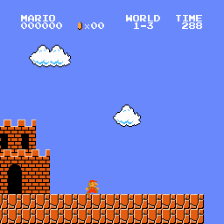

In [ ]:
# Dado que la función original de cv2.imshow no funciona en Colab es necesario importar el siguiente paquete
from google.colab.patches import cv2_imshow
#EDITABLE
# Con este podemos abrir cualquier imagen aleatoria de nuestro dataset de imagenes de entrenamiento
cv2_imshow(X_train[int(random.randint(0,len(X_train)))]) # Digita cualquier número menor a la longitud de la base de datos de entrenamiento para inspeccionar alguna imagen

## Preprocesamiento de los Datos

Dada la naturaleza de la importación de los datos, es importante trabajar finalmente solamente con arreglos númericos de imágenes. Para esto es importante realizar el siguiente proceso con cada una de las listas **(X)**. Para las etiquetas dada la naturaleza de la red convolucional que vamos a diseñar más adelante es necesario separar cada etiqueta en un vector doble. Es decir, ahora por cada dato que se tenga, se tendrá un vector de dos posiciones y el lugar donde se encuentre el 1 será la etiqueta correspondiente. Se puede evidenciar un ejemplo del mismo en la celda próxima a la que se encuentra a continuación.  

In [ ]:
# Las etiquetas ahora son trasnfromadas en vectores de dos posiciones 
Y_train_2cols = np.zeros((len(Y_train),2))
for i in range (0,len(Y_train)):
    if Y_train[i] == 0:
        Y_train_2cols[i,0] = 1
        Y_train_2cols[i,1] = 0
    else:
        Y_train_2cols[i,0] = 0
        Y_train_2cols[i,1] = 1
Y_val_2cols = np.zeros((len(Y_val),2))
for i in range (0,len(Y_val)):
    if Y_val[i] == 0:
        Y_val_2cols[i,0] = 1
        Y_val_2cols[i,1] = 0
    else:
        Y_val_2cols[i,0] = 0
        Y_val_2cols[i,1] = 1
Y_test_2cols = np.zeros((len(Y_test),2))
for i in range (0,len(Y_test)):
    if Y_test[i] == 0:
        Y_test_2cols[i,0] = 1
        Y_test_2cols[i,1] = 0
    else:
        Y_test_2cols[i,0] = 0
        Y_test_2cols[i,1] = 1

Y_train = Y_train_2cols 
Y_test = Y_test_2cols 
Y_val = Y_val_2cols 


# El comando np.asarray() convierte en arreglo númerico cualquier variable de entrada
# EDITABLE
X_train = np.asarray(X_train)
X_val = np.asarray(X_val) # borrar
X_test = np.asarray(X_test) # borrar

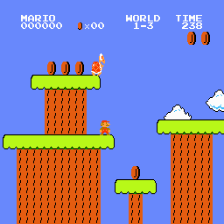

Etiqueta de la imagen:  [1. 0.]
Nivel de la imagen:  1
Clase a la que pertenece el dato:  0


In [ ]:
# Imagen 
cv2_imshow(X_train[0]) 
print("Etiqueta de la imagen: ", Y_train[0])
print("Nivel de la imagen: ", 1 if Y_train[0][0]==1 else 8)
print("Clase a la que pertenece el dato: ", 0 if Y_train[0][0]==1 else 1)

En la anterior celda como se puede corroborar en la imagen, se muestra un dato de la clase en especifico (0 o 1) la cuál corresponde a la posición en donde se encuentra el número 1 en su etiqueta. De igual forma esta se relaciona de forma directa con el nivel al que pertenece el dato inspeccionado (Nivel 1 u 8). Completa la siguiente celda:

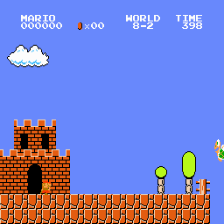

Etiqueta de la imagen:  [0. 1.]
A que nivel hace parte la anterior imagen según su etiqueta? 8
Bien hecho!


In [ ]:
# Imagen Nivel ?
# EJECUTABLE 
number = int(random.randint(0,len(X_train)))
cv2_imshow(X_train[number])
print("Etiqueta de la imagen: ", Y_train[number])
nivel = input('A que nivel hace parte la anterior imagen según su etiqueta? ')
true_lvl = 1 if Y_train[number][0] == 1 else 8
if int(nivel) == true_lvl:
  print('Bien hecho!')
else:
  print('Nivel equivocado! Intentalo de nuevo!')

# Red convolucional

## ¿Que es una red convolucional y como se compone?



Con el fin de construir un clasificador de imágenes robusto, se decidió usar una red neuronal convolucional (CNN) pre-entrenada. Las CNN hacen parte de una técnica de aprendizaje supervisado, la cual requiere datos de entrada y sus respectivas etiquetas como salida del modelo. Los datos son clasificados utilizando sus etiquetas para proveer un modelo aprendido para futuros análisis de imágenes. Normalmente una CNN está constituida por tres componentes principales:

* Capa convolucional 
* Capa de Pooling
* Red completamente conectada o _Fully Connnected_

En la siguiente figura se presenta un ejemplo de una CNN construida para clasificar imágenes de animales, en donde se observa cada una de las etapas de las redes convolucionales:

![Estructura de una red convolucional convencional](https://drive.google.com/uc?id=1KqD0UI_yS2sLrVCC6_g9q9NGIk1-FDV0)


Como se puede ver, la capa convolucional se encarga de tomar las imágenes de entrada y aplicar un total de _m_ filtros para poder hacer un mapeo de características. Luego, el mapa de características ingresa a la capa de _pooling_ para comenzar el procedimiento de reducción de dimensionalidad. Mediante éste se seleccionan únicamente las características relevantes del mapa de caracerísticas. Finalmente, todas las características pasan por una capa _flatten_; el proceso de _flattening_ consiste en transformar una matriz de características en un vector, el cual corresponde a la entrada de la última etapa, la red completamente conectada. Es en esta última parte de la CNN donde se lleva acabo la clasificación.

De acuerdo con lo anterior, es importante recalcar que el entrenamiento de una red convolucional tiene un **alto costo computacional** según sea su profundidad. Según el número de filtros que tenga cada una de las capas convolucionales y el número de capas con la que cuenta le red en total, asimismo será de complejo su entrenamiento. 

Ahora bien, para comenzar el diseño de nuestra propia red convolucional, es necesario importar ciertos paquetes de python. 


In [ ]:
# Importación de paquetes necesarios para la creación de nuestra red convolucional
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


## Diseño y entrenamiento del modelo

En primer lugar nos vamos asegurar que el sistema cuenta con GPU para poder obtener un menor tiempo de entrenamiento. **Para asegurarte que cuentas con este recurso ejeuta la siguiente celda. Si al ejecutarla te sale el siguiente error:**

'GPU device not found'

Es necesario que te vayas a la pestaña (en la barra de herramientas superior izquierda) de **"Entorno de ejecución"** -> **"Cambiar entorno de entorno de ejecución"** y finalmente en **"Aceleradoor de Hardware" debes seleccionar** **GPU** tal y como se muestra en la siguiente imagen. 

![GPU](https://drive.google.com/uc?id=1tG5-vZ4ubS0T1ItFj7MXlsffgKSa5VfS)

In [ ]:
# En primer lugar verificamos el uso de la GPU
%tensorflow_version 2.x
import tensorflow as tf
from numpy.random import seed
seed(1)
tf.random.set_seed(2)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Ahora bien, la arquitectura que se manejará para este caso de clasificación será: 
- **Capa convolucional** (16 filtros)
- **Capa convolucional** (64 filtros)
- **Capa Max Pooling** (Pool size (2,2)) - Se encarga de realizar la reducción de dimensionalidad después de las capas convolucionales
- **Capa Dropout** - Ayuda a disminuir overfitting o sobre-entrenamiento
- **Capa Flatten** - Se encarga de volver la salida matricial en un solo vector
- **Etapa completamente conectada** - Etapa que modificaremos para mejorar el desempeño del modelo

Ahora bien, se eligieron tan pocas capas convolucionales para disminuir el tiempo de ejecución y entrenamiento del modelo. El objetivo de las celdas que vienen a continuación es encontrar la función de activación óptima, el algoritmo de entrenamiento óptimo para esta arquitectura, el número de neuronas por capa y el número de capas que tengan un mejor desempeño en la etapa completamente conectada. 

Para la celda que viene a continuación se escogerá la función de activación que se utilizará para las capas ocultas en la parte completamente conectada. Esto se realizará con el objetivo no solamente de escoger la función de activación con mejor desempeño sino también para explorar que funciones de activación existen y cuales funcionan para este tipo de datos y cuales no. Para esto se usará un número de neuronas estándar, el cuál después será hallado de forma óptima. 

Dentro de TensorFlow existen diferentes tipos de funciones de activación, entre ellas se encuentran:

- Lineal o 'linear'
- Tengente hiperbolica o 'tanh'
- Relu o 'relu'

Complete, en el campo de función de activación, un vector de las anteriores funciones de activación y el número de epocas con el que desea entrenar su modelo. **Recuerde tener en cuenta la notación especificada entre comillas anteriormente** 






In [ ]:
with tf.device('/device:GPU:0'):
  # Número de neuronas para la primera capa oculta
  # EDITABLE 
  N = 100  # Numero de nueronas
  epocas = 10 # borrar - Ejemplo: 5
  funcionActivacion = ['linear', 'tanh', 'relu'] # borrar - Ejemplo: ['linear',...]
  # Función de activación a comparar
  best_activation_function_model = 'any'
  # Comparación de exactitud
  best_acc = 0.5
  # Vector de exactitud
  accuracy_model = []
  # Vector de error
  loss_function = []
  for function in funcionActivacion:
    print("Creating new model")
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(5, 5),
                activation=function,
                input_shape=(224,224,3)))
    model.add(Conv2D(64, (3, 3), activation=function))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(N, activation=function))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=function))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
    print("Entrenamiento con función de activación: "+str(function))
    model.fit(X_train, Y_train, batch_size = 128, epochs=epocas, verbose= 1)
    mse, test_acc = model.evaluate(X_val, Y_val, verbose = 1)
    accuracy_model.append(test_acc)
    loss_function.append(mse)
    if test_acc > best_acc:
      bestError = mse
      best_activation_function_model = function
      best_acc = test_acc
    print("Función "+ function + ": ")
    print("Exactitud presentada: " + str(test_acc))
  clear_output(wait=True)
  print("Función de activación con mejor exactitud: "+str(best_activation_function_model))
  print("Exactitud: "+str(best_acc))


Función de activación con mejor exactitud: relu
Exactitud: 0.9313333630561829


Una vez se determina cuál es la función de activación óptima para la parte completamente conectada, es necesario determinar los demás parámetros. Si se quiere evidenciar de forma gráfica el resultado de las diferentes funciones de activación evaluadas, basta con ejecutar la siguiente celda: 

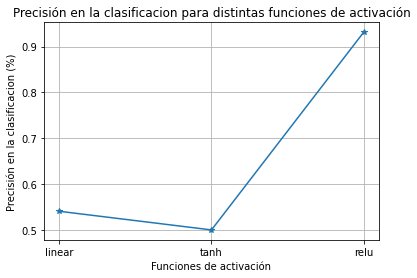

In [ ]:
# Grafica de precisión vs funciones de activación para la capa oculta evaluada anteriormente
plt.plot(funcionActivacion, accuracy_model, '*-')
plt.title('Precisión en la clasificacion para distintas funciones de activación')
plt.xlabel('Funciones de activación')
plt.ylabel('Precisión en la clasificacion (%)')
plt.grid(b=True)
plt.show()

Para la celda que viene a continuación se escogerá el algoritmo de entrenamiento  que se utilizará para las capas ocultas en la parte completamente conectada. Esto se realizará con el objetivo no solamente de escoger el algoritmo de entrenamiento con mejor desempeño sino también para explorar que algoritmos existen y cuales funcionan para este tipo de datos y cuales no. Para esto se usará un número de neuronas estándar  el cuál después será hallado de forma óptima y la función de activación óptima hallada anteriormente. 

Dentro de TensorFlow existen diferentes tipos de algoritmos de entrenamiento, entre estos se encuentran:

- SGD - Stochastic Gradient Descent o 'sgd'
- Adam Optimizer o 'adam'
- Adagrad Optimizer o 'adagrad'

Complete, en el campo de algoritmo de entrenamiento, un vector de los anteriores algoritmos de entrenamientos mencionados, la función de activación con mejor desempeño previamente hallada y el número de epocas con el que desea entrenar su modelo. **Recuerde tener en cuenta la notación especificada entre comillas anteriormente** 

In [ ]:
with tf.device('/device:GPU:0'):
  # Número de neuronas para la primera capa oculta
  # EDITABLE 
  N = 100  # Numero de nueronas
  epocas = 10 # borrar - Ejemplo: 5
  funcionActivacion = 'relu' # borrar - Ejemplo: 'linear' - Encontrada anteriormente
  algoritmosEntrenamiento = ['sgd', 'adam', 'adagrad'] # borrar - Ejemplo: ['sgd',....]
  # Algoritmos de entrenamiento a comparar
  best_algorithm_model = 'any'
  # Comparación de exactitud
  best_acc = 0.5
  # Vector de exactitud
  accuracy_model = []
  # Vector de error
  loss_function = []
  for algorithm in algoritmosEntrenamiento:
    print("Creating new model")
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(5, 5),
                activation='relu',
                input_shape=(224,224,3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(N, activation=funcionActivacion))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=funcionActivacion))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=algorithm,
              metrics=['accuracy'])
    print("Entrenamiento con algoritmo de entrenamiento: "+str(algorithm))
    model.fit(X_train, Y_train, batch_size = 128, epochs=epocas, verbose= 1)
    mse, test_acc = model.evaluate(X_val, Y_val, verbose = 1)
    accuracy_model.append(test_acc)
    loss_function.append(mse)
    if test_acc > best_acc:
      bestError = mse
      best_algorithm_model = algorithm
      best_acc = test_acc
    print("Algoritmo "+ algorithm + ": ")
    print("Exactitud presentada: " + str(test_acc))
  clear_output(wait=True)
  print("Algoritmo de entrenmiento con mejor exactitud: "+str(best_algorithm_model))
  print("Exactitud: "+str(best_acc))

Algoritmo de entrenmiento con mejor exactitud: adam
Exactitud: 0.9493333101272583


Una vez se determina cuál es la función de activación óptima para la parte completamente conectada, es necesario determinar los demás parámetros. Si se quiere evidenciar de forma gráfica el resultado de las diferentes funciones de activación evaluadas, basta con **completar la siguiente celda**. Siguiendo el anterior ejemplo, grafique la precisión que se obtuvo con los diferentes algoritmos de entrenamiento previamente descritos y ejecutados. 

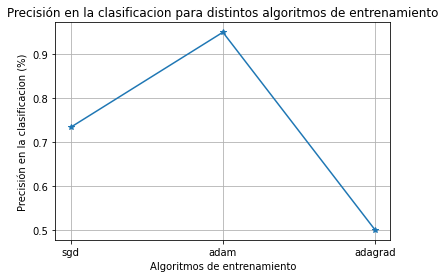

In [ ]:
#EDITABLE
# Grafica de precisión vs algoritmos de entrenamiento para la capa oculta evaluada anteriormente
plt.plot(algoritmosEntrenamiento, accuracy_model, '*-') # borrar
plt.title('Precisión en la clasificacion para distintos algoritmos de entrenamiento') # borrar
plt.xlabel('Algoritmos de entrenamiento') # borrar
plt.ylabel('Precisión en la clasificacion (%)') # borrar
plt.grid(b=True) # borrar
plt.show() # borrar

Para la celda que viene a continuación se escogerá para una capa oculta el número de neuronas óptimo para la misma. Esta validación cruzada se realiza con los datos de validación anteriormente separados y ajenos al proceso de entrenamiento para obtener un porcentaje de precisión valido y probado en datos diferentes. 

**Complete el número de neuronas sobre las cuales desea iterar, el número de epocas que desea que se entrene el modelo, el algoritmo de entrenamiento y la función de activación obtenidos ambos anteriormente. **

In [ ]:
with tf.device('/device:GPU:0'):
  # Número de neuronas para la primera capa oculta
  # EDITABLE 
  N = [50,100,200]  # borrar - Ejemplo: [50,100,200]
  epocas = 10 # borrar - Ejemplo: 5
  funcionDeActivacion = 'relu' # borrar - Determinada anteriormente
  algoritmoEntrenamiento = 'adam' # borrar - Determinado anteriormente
  # Comparación de exactitud
  best_acc = 0.5
  # Numero de neuronas a compara
  best_neurons_model = 2
  # Vector de exactitud
  accuracy_model = []
  # Vector de error
  loss_neurons = []
  for i in range(0,len(N)):
    print("Creating new model")
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(5, 5),
                 activation=funcionDeActivacion,
                 input_shape=(224,224,3)))
    model.add(Conv2D(64, (3, 3), activation=funcionDeActivacion))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(N[i], activation=funcionDeActivacion))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=funcionDeActivacion))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=algoritmoEntrenamiento,
              metrics=['accuracy'])
    print("Entrenamiento con: "+str(N[i])+" neuronas")
    model.fit(X_train, Y_train, batch_size = 128, epochs=epocas, verbose= 1)
    mse, test_acc = model.evaluate(X_val, Y_val, verbose = 1)
    accuracy_model.append(test_acc)
    loss_neurons.append(mse)
    if accuracy_model[i] > best_acc:
      best_acc = accuracy_model[i]
      best_neurons_model = N[i]
    print(i)
  clear_output(wait=True)
  print("Numero de neuronas con mejor exactitud: "+str(best_neurons_model))
  print("Exactitud: "+str(best_acc))


Creating new model
Entrenamiento con: 50 neuronas
Epoch 1/10
7000/7000 [==============================] - 42s 6ms/step - loss: 2.0619 - accuracy: 0.5163
Epoch 2/10
7000/7000 [==============================] - 42s 6ms/step - loss: 0.7065 - accuracy: 0.6207
Epoch 3/10
7000/7000 [==============================] - 42s 6ms/step - loss: 0.5872 - accuracy: 0.6586
Epoch 4/10
7000/7000 [==============================] - 42s 6ms/step - loss: 0.6287 - accuracy: 0.7000
Epoch 5/10
7000/7000 [==============================] - 42s 6ms/step - loss: 0.5334 - accuracy: 0.7357
Epoch 6/10
7000/7000 [==============================] - 41s 6ms/step - loss: 0.5009 - accuracy: 0.8133
Epoch 7/10
7000/7000 [==============================] - 41s 6ms/step - loss: 0.3689 - accuracy: 0.8953
Epoch 8/10
7000/7000 [==============================] - 41s 6ms/step - loss: 0.2624 - accuracy: 0.8971
Epoch 9/10
7000/7000 [==============================] - 41s 6ms/step - loss: 0.2156 - accuracy: 0.8569
Epoch 10/10
1500/1500 [

ResourceExhaustedError: ignored

Una vez se determina cuál es el número de nueronas óptimo para la capa oculta de la parte completamente conectada, es necesario determinar el número de capas ocultas en dicha parte completamente conectada. Si se quiere evidenciar de forma gráfica el resultado del diferente número de neuronas evaluado, basta con **completar la siguiente celda**: 

In [ ]:
# EDITABLE
# Grafica de precisión vs número de neuronas en la capa oculta evaluada anteriormente
plt.plot(N, accuracy_model, '*-') # borrar
plt.title('Precisión en la clasificacion para distintas neuronas') # borrar
plt.xlabel('Numero de neuronas (N)') # borrar
plt.ylabel('Precisión en la clasificacion (%)') # borrar
plt.grid(b=True) # borrar
plt.show() # borrar

Ahora bien, con el número de neuronas óptimo por capa oculta en la etapa complemente conectada se puede determinar el número de capas ocultas óptimo que se debe tener para obtener un buen desempeño del modelo. Complete el número de neuronas obtenido anteriormente, el número de capas ocultas sobre las cuales desea iterar y probar y el número de epocas que desea entrenar su modelo:

In [ ]:
with tf.device('/device:GPU:0'):
  # Número de neuronas para la primera capa oculta
  # EDITABLE 
  N = 100  # borrar - Número de neuronas por capa oculta encontrada anteriormente - Ejemplo: 100
  layers = [2,3,4] # borrar - Número de capas ocultas a variar y probar con el número de neuronas encontrado anteriormente - Ejemplo: [2,3,4]
  epocas = 10 # borrar - Ejemplo: 5
  funcionDeActivacion = 'relu' # borrar - Determinada anteriormente
  algoritmoEntrenamiento = 'adam' # borrar - Determinado anteriormente
  # Comparación de exactitud
  best_acc = 0.5
  # Numero de capas a compara
  best_layer_model = 1
  # Vector de exactitud
  accuracy_model = []
  # Vector de error
  loss_neurons = []
  for i in range(0,len(layers)):
    print("Creating new model")
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(5, 5),
                 activation=funcionDeActivacion,
                 input_shape=(224,224,3)))
    model.add(Conv2D(64, (3, 3), activation=funcionDeActivacion))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    for j in range(layers[i]):
      model.add(Dense(N, activation=funcionDeActivacion))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=funcionDeActivacion))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=algoritmoEntrenamiento,
              metrics=['accuracy'])
    print("Entrenamiento con: "+str(layers[i])+" capas ocultas")
    model.fit(X_train, Y_train, batch_size = 128, epochs=epocas, verbose= 1)
    mse, test_acc = model.evaluate(X_val, Y_val, verbose = 1)
    accuracy_model.append(test_acc)
    loss_neurons.append(mse)
    if accuracy_model[i] > best_acc:
      best_acc = accuracy_model[i]
      best_layer_model = layers[i]
  clear_output(wait=True)
  print("Numero de capas con mejor exactitud: "+str(best_layer_model))
  print("Exactitud: "+str(best_acc))

Una vez se determina cuál es el número de capas ocultas óptimo para nuestro modelo, este se encuentra listo para su evaluación final.**Vale la pena aclarar que este número de capas ocultas puede llegar a ser solamente 1 y tener un desempeño mejor que con multiples capas.** Si se quiere evidenciar de forma gráfica el resultado del diferente número de neuronas evaluado, basta con ejecutar la siguiente celda (Completa la siguiente celda siguiendo los anteriores ejemplos): 

In [ ]:
# Grafica de precisión vs número de capas ocultas
# EDITABLE
plt.plot(layers, accuracy_model, '*-') # borrar
plt.title('Precisión en la clasificacion para distintas capas ocultas') # borrar
plt.xlabel('Numero de capas ocultas (N)') # borrar
plt.ylabel('Precisión en la clasificacion (%)') # borrar
plt.grid(b=True) # borrar
plt.show() # borrar

**Vale la pena aclarar que bajo esta metodología todas las capas de la parte completamente conectada tienen el mismo número de neuronas óptimo obtenido anteriormente**. De esta forma se garantiza un buen desempeño del modelo según el objetivo planteado inicialmente. Sin embargo, si se quiere mejorar dicho desempeño lo recomendado sería utilizar una validación de tipo matricial en donde se evaluen el número de neuronas y el número de capas ocultas al mismo tiempo. Esta metodología no se implementó ya que este es solo un ejercicio introductorio a redes convolucionales y esto incrementaría el tiempo de entrenamiento del modelo. 

## Evaluación del modelo

Una vez se realiza todo el proceso de entrenamiento y validación cruzada para determinar los parámetros del modelo convolucional, es necesario evaluar su precisión final y ver su resultado. Para esto, utilizaremos los datos de **Test** separados inicialmente. Complete en la siguiente celda el número de neuronas por capa, el número de capas optimas y el número de épocas con el fin de entrenar el modelo final. 

In [ ]:
with tf.device('/device:GPU:0'):
  from keras.models import Sequential, Model
  from keras.layers import Dense, Input, Flatten
  # Entrenamiento del modelo final
  # EDITABLE
  N = 100 # borrar - Número de neuronas por capa oculta óptimo obtenido - COMPLETAR - Número obtenido anteriormente 
  layers = 2 # borrar - Número de capas ocultas óptimo obtenido - COMPLETAR - Número obtenido anteriormente
  epocas = 10 # borrar - Número de capas ocultas óptimo obtenido - COMPLETAR
  funcion = 'relu' 
  algoritmo = 'adam'
  model_final = Sequential()
  model_final.add(Conv2D(16, kernel_size=(5, 5),
                 activation=funcion,
                 input_shape=(224,224,3)))
  model_final.add(Conv2D(64, (3, 3), activation=funcion))
  model_final.add(MaxPooling2D(pool_size=(2, 2)))
  model_final.add(Dropout(0.25))
  model_final.add(Flatten())
  for j in range(layers):
    model_final.add(Dense(N, activation=funcion))
  model_final.add(Dropout(0.5))
  model_final.add(Dense(2, activation=funcion))
  model_final.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=algoritmo,
              metrics=['accuracy'])
  print("Entrenamiento modelo final: "+str(layers)+" capas ocultas, "+str(N)+" neuronas por capa")
  model_final.fit(X_train, Y_train, batch_size = 128, epochs=epocas, verbose= 1)
  mse, test_acc = model_final.evaluate(X_test, Y_test, verbose = 1)
  print('---------- Final model Model ------------')
  print('----- Precisión: ',test_acc)
  print('----- Porcentaje de Error: ',mse)

Entrenamiento modelo final: 2 capas ocultas, 100 neuronas por capa
Epoch 1/10
7000/7000 [==============================] - 31s 4ms/step - loss: 1.0881 - accuracy: 0.5340
Epoch 2/10
7000/7000 [==============================] - 20s 3ms/step - loss: 0.5760 - accuracy: 0.7033
Epoch 3/10
7000/7000 [==============================] - 20s 3ms/step - loss: 0.4810 - accuracy: 0.7497
Epoch 4/10
7000/7000 [==============================] - 20s 3ms/step - loss: 0.4400 - accuracy: 0.8206
Epoch 5/10
7000/7000 [==============================] - 21s 3ms/step - loss: 0.2885 - accuracy: 0.9134
Epoch 6/10
7000/7000 [==============================] - 21s 3ms/step - loss: 0.1716 - accuracy: 0.9724
Epoch 7/10
7000/7000 [==============================] - 20s 3ms/step - loss: 0.0424 - accuracy: 0.9811
Epoch 8/10
7000/7000 [==============================] - 20s 3ms/step - loss: 0.0695 - accuracy: 0.9834
Epoch 9/10
7000/7000 [==============================] - 20s 3ms/step - loss: 0.0300 - accuracy: 0.9926
Epoch 

Como se puede observar se obtuvo un modelo con un buen desempeño. En caso de que se quiera probar en realidad se puede tomar una de esas imágenes de Test y probar cual es su clase. Para ello, basta con ejecutar la siguiente celda: 

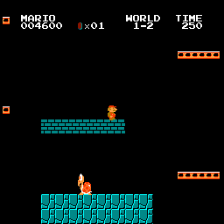

Clase a la que pertece:  0
Nivel de la imagen seleccionada:  1
Clase predicha por el modelo:  0
Nivel predicho por el modelo:  1


In [ ]:
# EDITABLE
imagen_seleccionada = 101 # borrar - Numero de la longitud de las imagenes de test
cv2_imshow(X_test[imagen_seleccionada]) 
print("Clase a la que pertece: ",0 if Y_test[imagen_seleccionada][0] > Y_test[imagen_seleccionada][1] else 1)
print("Nivel de la imagen seleccionada: ",1 if Y_test[imagen_seleccionada][0] == 1 else 8)
print("Clase predicha por el modelo: ",0 if model_final.predict(np.array([X_test[imagen_seleccionada]]))[0][0]>model_final.predict(np.array([X_test[imagen_seleccionada]]))[0][1] else 1)
print("Nivel predicho por el modelo: ",1 if model_final.predict(np.array([X_test[imagen_seleccionada]]))[0][0]>model_final.predict(np.array([X_test[imagen_seleccionada]]))[0][1] else 8)

Otra manera de comprobar el desemepeño final del modelo es utilizando una matriz de confusión. Esta es una matriz que compara el número de datos etiquetados de forma correcta y el número de datos etiquetados de forma incorrecta. Básicamente estás matrices indican cuantos datos (del número total de datos utilizados para validación o en como en este caso para test) que hacen parte de una clase son clasificados de forma correcto o incorrecta. Por ejemplo en la siguiente tabla se muestra la matriz de confusión para un caso de clasificación binaria. En esta se muestra en la primera fila las etiquetas originales de los datos y en la primera columna las etiquetsa predichas por el modelo. Las letras que se encuentran dentro de dicha tabla representan el número de datos clasificados para cada una de las etiquetas correspondientes. Es decir, existen **n** datos que pertenecen a la **clase 1** y fueron clasificados como pertenecientes a la **clase 1**. De igual forma existen **p** datos que pertenecen a la **clase 0** que fueron clasificados por el modelo a la **clase 1**. Esto mismo ocurre con el número de datos **m** y **q**.  

>Etiqueta Predicha\Original | 1 | 0
>--- | --- | ---
>1 | n | p
>0 | m | q

De esta forma si **n** y **q** (Los números en la digonal de la matriz) son muy grandes en comparación con los números **p** y **m** (**n>>p y q>>m**) implica que el modelo esta bien construido y tiene un muy buen desempeño. De igual forma si ocurre lo contrario (**n<<p y q<<m**) o los números son iguales o parecidos (**n=p=q=m**) significa que hace falta ajustar diversos parámetros en el modelo. 

En la siguiente celda calcularemos la matriz de confusión para nuestro modelo final. Para esto usaremos una función de tensorflow y posteriormente mostrar el resultado



In [ ]:
# MATRIZ DE CONFUSIÓN
# Vectores de etiquetas a comparar
Y_predict = []
Y_labels = []
for i in range(len(X_test)):
  Y_predict.append(0) if model_final.predict(np.array([X_test[i]]))[0][0]>model_final.predict(np.array([X_test[i]]))[0][1] else Y_predict.append(1) 
  Y_labels.append(0) if Y_test[i][0]>Y_test[i][1] else Y_labels.append(1)
confussion_Matrix = tf.math.confusion_matrix(Y_labels, Y_predict, num_classes=2, weights=None, dtype=tf.dtypes.int32).numpy()
print(confussion_Matrix)

[[737  13]
 [  1 749]]


Ahora bien, de acuerdo con la matriz de confusión obtenida anteriormente responde la siguiente pregunta:

Nota: **Responde Si o No**


In [ ]:
ans = input('¿Crees que el modelo esta bien diseñado? ')
if ans == 'Si' or ans == 'si':
  print('Correcto! Buen trabajo!') if (confussion_Matrix[0,0]>confussion_Matrix[0,1] and confussion_Matrix[1,1]>confussion_Matrix[1,0]) else print('Deberías revisar mejor la matriz de confusión y volver a responder la pregunta')
if ans == 'No' or ans == 'no':
  print('Tienes razón! Revisa de nuevo los parámetros del modelo y vuelve a entrenarlo') if (confussion_Matrix[0,1]>confussion_Matrix[0,0] and confussion_Matrix[1,0]>confussion_Matrix[1,1]) else print('Deberías revisar mejor la matriz de confusión y volver a responder la pregunta')

¿Crees que el modelo esta bien diseñado?si
Correcto! Buen trabajo!


# Trabajo Adicional

A esta punto queda claro que la validación cruzada y el barrido de parámetros tienen un buen desempeño. Sin embargo, como se aclaró anteriormente, sería mucho mejor si se realizará de forma matricial y se incluyeran otros parámetros adicionales incluyendo más la parte convolucional de la red que estamos evaluando. Es por esto que como trabajo adicional a este módulo se propone realizar esta validación cruzada de forma matricial y verificar los resultados con los obtenidos anteriormente para obtener conclusiones adicionales de la metodología realizada a lo largo de este módulo. Para esto te proponemos que realices los siguientes pasos: 

1. Realiza el mismo procedimiento hasta antes de **"Diseño y entrenamiento del modelo"**
2. Allí realiza un procedimiento parecido al que realizamos con las funciones de activación, añadiendo los vectores de: 
  - Funciones de activación
  - Algoritmo de entrenamiento
  - Número de neuronas por capa oculta
  - Número de capas ocultas 
3. Una vez definas los cuatro vectores sobre los cuales vamos a iterar se debe crear las matrices de _precision_ y _error_. Estas pueden crearse como _np.matrix_. **Recuerda estas matrices tendrán varias dimensiones**. Por ejemplo, si decides pobrar con **3** funciones de activación, **4** algortimos de entrenamiento, **5** opciones de neuronas para la capa oculta y **4** opciones de número de capas ocultas las dimensiones de tu matriz deben ser de **3x4x5x4 o (3,4,5,4)**

4. Seguido de esto, lo único restante es realizar el recorrido múltiple en el cuál se crea y evlua un modelo variando sus parámetros. 

5. Por cada modelo creado dentro del recorrido es necesario entrenar el modelo con los datos de entrenamiento y validar su desempeño con los datos de validación.

6. El desempeño de cada modelo será almacenado posteriormente en nuestra matriz de _presición_ y _error_. 

7. Finalmente al recorrer dicha matriz de precisiones y errores se puede determinar cuales son los parámetros ideales del modelo para finalmente completarlos en **"Evaluación del modelo"** y así comparar las metodologías